In [22]:
from datasets import load_dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [11]:
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


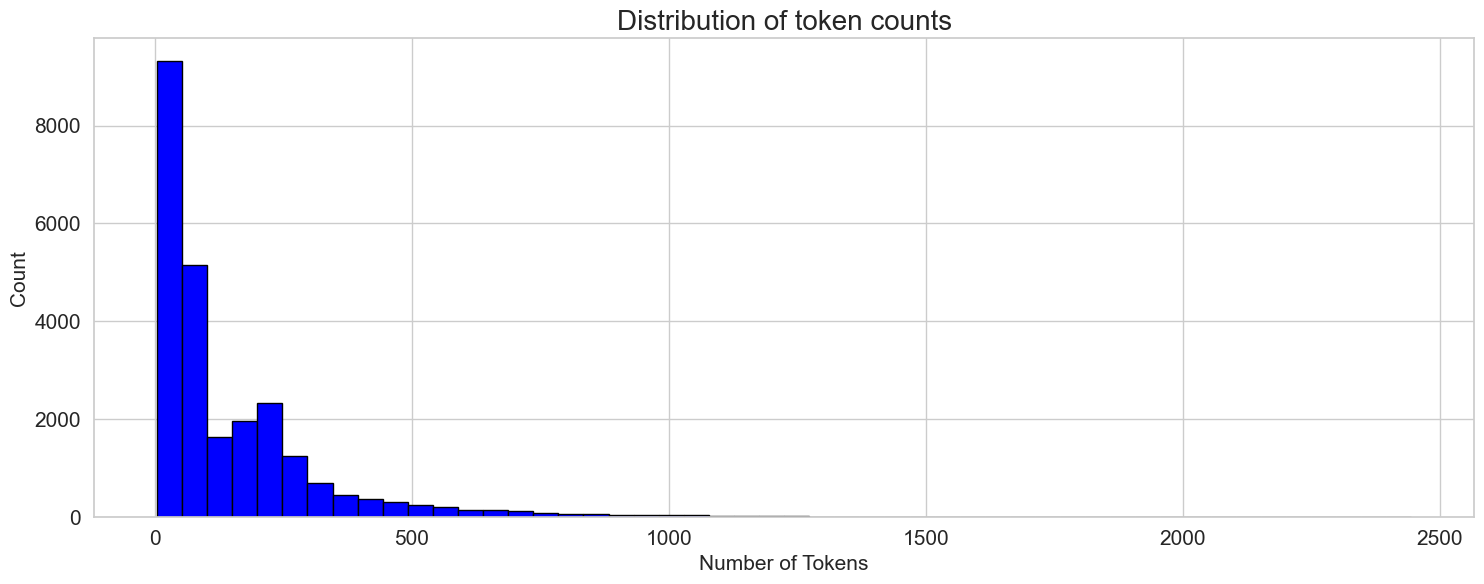

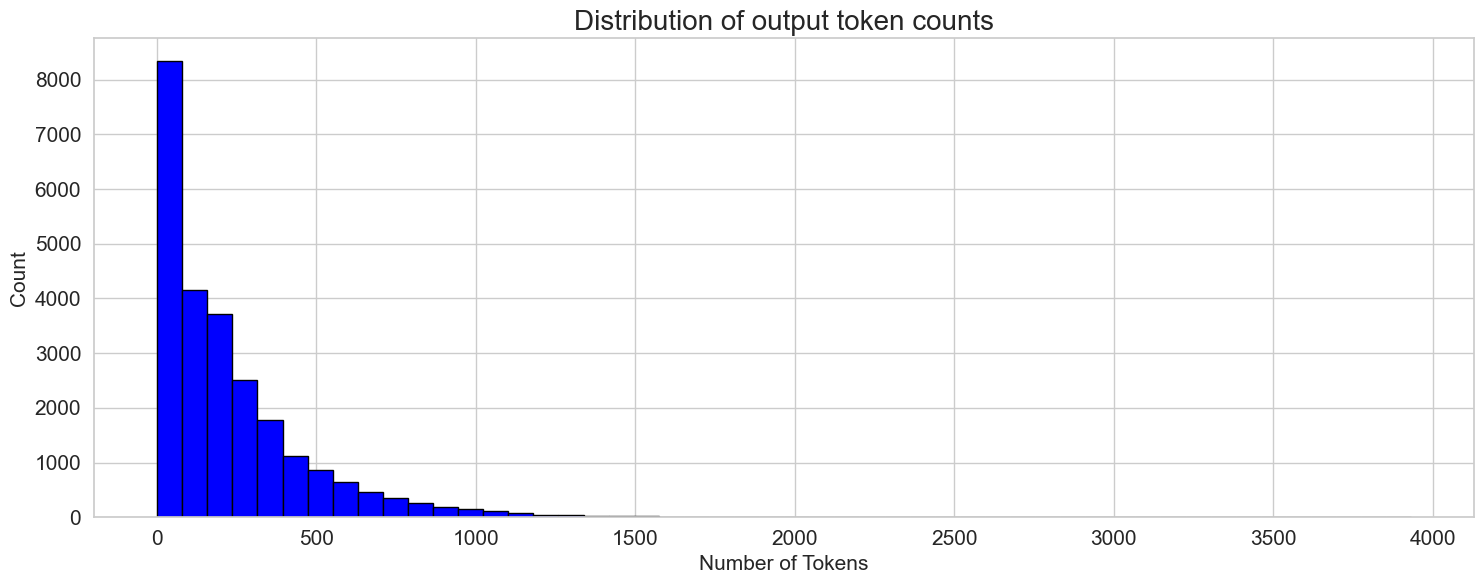

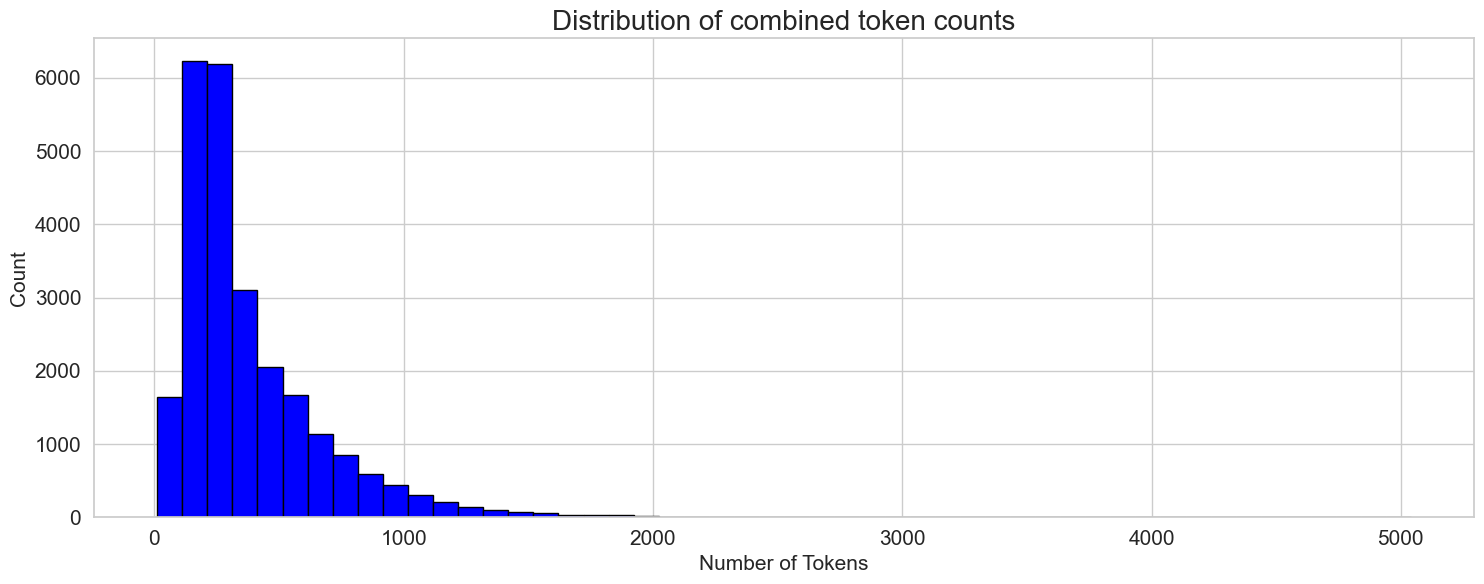

In [12]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
instructions_tok_counts = [len(tokenizer.tokenize(i)) for i in dataset['train']['instruction']]
output_tok_counts = [len(tokenizer.tokenize(i)) for i in dataset['train']['output']]
combined_tok_counts = [instruction + output for instruction, output in zip(instructions_tok_counts, output_tok_counts)]


def plot_distribution(token_counts, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='blue', edgecolor='black')
    plt.title(title, fontsize=20)
    plt.xlabel('Number of Tokens', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    
plot_distribution(instructions_tok_counts, "Distribution of token counts")
plot_distribution(output_tok_counts, "Distribution of output token counts")
plot_distribution(combined_tok_counts, "Distribution of combined token counts")

In [13]:
import torch

max_seq_len = torch.max(torch.tensor(instructions_tok_counts))
max_seq_len

tensor(2445)

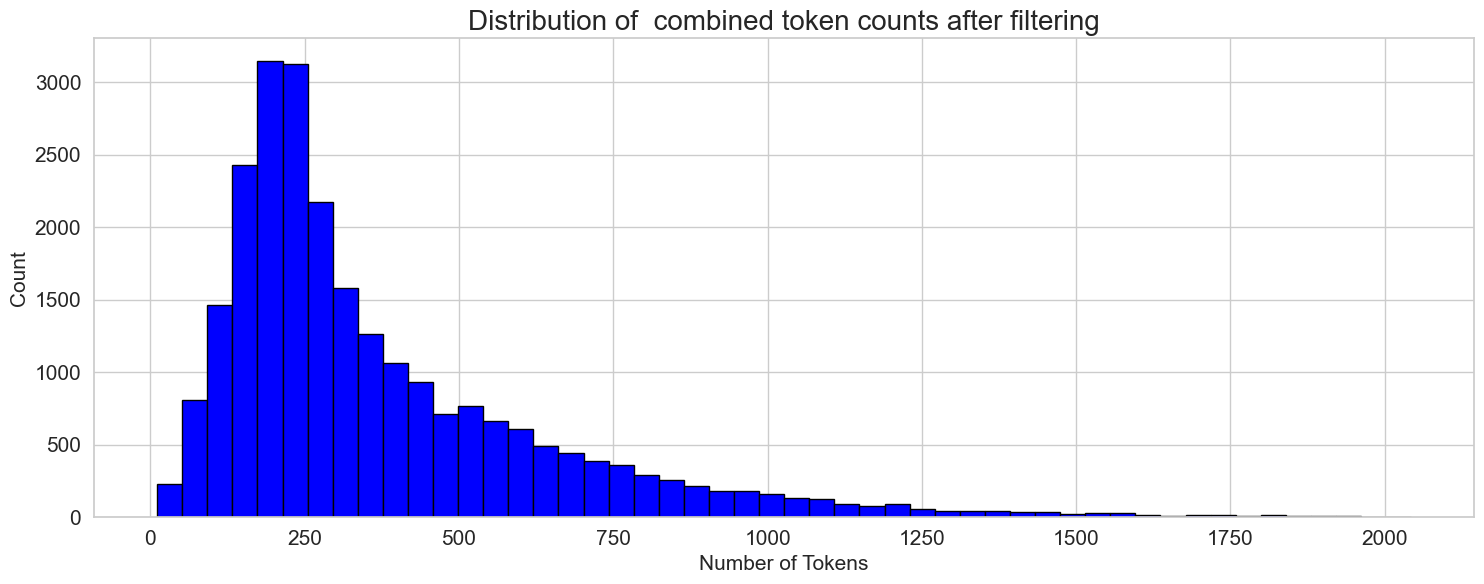

In [14]:
# Filter out rows with more than 2048
valid_indices = [i for i, x in enumerate(combined_tok_counts) if x <= 2048]
len(valid_indices)

dataset['train'] = dataset['train'].select(valid_indices)

token_counts = [combined_tok_counts[i] for i in valid_indices]

plot_distribution(token_counts, "Distribution of  combined token counts after filtering")

In [15]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import DatasetDict, Dataset
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset, model_name, threshold: float, batch_size=32, device='cpu'):
    model = SentenceTransformer(model_name, device=device)
    outputs = [example['output'] for example in dataset['train']]
    print("Computing embeddings for outputs")
    embeddings = model.encode(outputs, batch_size=batch_size, show_progress_bar=True)
    index = faiss.IndexFlatIP(embeddings.shape[1])
    norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(norm_embeddings)
    
    print("Deduplicating dataset")
    D, I = index.search(norm_embeddings, k=2)
    to_keep = []
    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        if D[i, 1] < threshold:
            to_keep.append(i)
    dataset = dataset['train'].select(to_keep)
    return DatasetDict({'train': dataset})

import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = 'cpu'
else:
    device = 'mps'
    print("MPS is available and will be used.")

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-small", 0.95, device=device)

MPS is available and will be used.
Computing embeddings for outputs


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Deduplicating dataset


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [16]:
print(f"Dataset size before deduplication: {len(dataset['train'])}")
print(f"Dataset size after deduplication: {len(deduped_dataset['train'])}")

Dataset size before deduplication: 24895
Dataset size after deduplication: 15698


In [23]:
def get_top_k_rows(dataset: Dataset, tok_counts, k: int):
    sorted_indices = sorted(range(len(tok_counts)), key=lambda i: tok_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]
    
    top_k_data = {
        "instruction": [dataset['train'][i]['instruction'] for i in top_k_indices],
        "output": [dataset['train'][i]['output'] for i in top_k_indices],
    }
    return Dataset.from_dict(top_k_data)

k = 1000
top_k_dataset = get_top_k_rows(dataset, combined_tok_counts, k)
dataset = DatasetDict({'train': top_k_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 1000
    })
})

In [24]:
def chat_template(example):
    example['instruction'] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nЭкранируй этот Markdown:\n\n...,С удовольствием. Вот ваш исходный код с экрани...
1,### Instruction:\nThe polynomial $f(x)=x^{2007...,We know the polynomial $P$ has degree $2007$. ...
2,### Instruction:\nTwo identical rectangular cr...,"In Crate A, we have 20 rows of 10 pipes packed..."
3,### Instruction:\nsummarise the following in 3...,"Mox Bank, a virtual-only lender in Hong Kong, ..."
4,### Instruction:\nConsider two lines: line $l$...,"As usual, we start by graphing these lines. An..."
...,...,...
995,### Instruction:\nCompute\n\[\cos^3 \frac{2 \p...,The triple angle formula states that $\cos 3 \...
996,### Instruction:\nDesign a PHP web application...,To create a PHP web application that allows us...
997,"### Instruction:\nIn the diagram, $AB = 13\tex...",We extend $AD$ to the point $E$ where it inter...
998,### Instruction:\nLet $ABCDEF$ be a regular he...,[asy] defaultpen(0.8pt+fontsize(12pt)); pair A...
